## VICTOR: Intro to ODEs, 2: pressure in a magma reservoir and expected deformation


### Magma pressure and displacement

First consider a simple model of the change in magma reservoir pressure as a function of time

$$\frac{dP}{dt} = \frac{\mu}{V} \left [Q_{in}(t) - Q_{out} (t) \right ] $$

where $P$ (Pa) is the magma reservoir pressure, which varies as a function of time, $t$ (s). $\mu$ (Pa) is the shear modulus, $V$ (m$^3$) is the reservoir volume, and $Q_{in}(t)$ (m$^3$/s) and $Q_{out} (t)$ are the magma flow in and magma flow out of the reservoir , respectively.

Consider the case where the flux into the  reservoir is greater than the flux out - this just leads to a linear increase in pressure with time.

In the following this problem is solved with a fourth order Runge-Kutta algorithm. A bit overkill for this initial problem! But note how keyword arguments (kwargs) are used to pass information among functions. In this case, the information needed to solve for $\frac{dP}{dt}$ includes the shear modulus, volume, volume flux in and volume flux out.

In [19]:
def RK4(deriv,t, p, h, total_t, **kwargs):
    #fourth order R-K solution
    tout = []
    pout = []
    while (t < total_t):
        
        # R-K solution
        dp_dt = deriv(t,p, **kwargs)
        k1=dp_dt
        dp_dt= deriv(t+0.5*h, p+0.5*h*k1, **kwargs)
        k2 = dp_dt
        dp_dt  = deriv(t+0.5*h, p+0.5*h*k2, **kwargs)
        k3 = dp_dt
        dp_dt = deriv(t+h, p+h*k3, **kwargs)
        k4 = dp_dt
        p += h/6.*(k1+2.*k2+2.*k3+k4)
        t += h
        
        #build output lists
        pout.append(p) # concatenate the lists
        tout.append(t)
        
    
    return tout, pout



In [20]:
# The ODE
def deriv(t,p,shear_modulus, volume, volume_flux_in, volume_flux_out):
    return shear_modulus/volume*(volume_flux_in - volume_flux_out)


In [21]:
#initial conditions
kwargs={"shear_modulus": 1.4e10, #Pa
       "volume": 1e9, #m3
       "volume_flux_in": 10, #m3/s
       "volume_flux_out":5}

#set the initital conditions
t = 0
p = 50e6 #Pa

#set the step 1000 s
h = 60
total_t = 24*60*h

#solve the ODE
tout, pout = RK4(deriv,t, p, h, total_t, **kwargs)

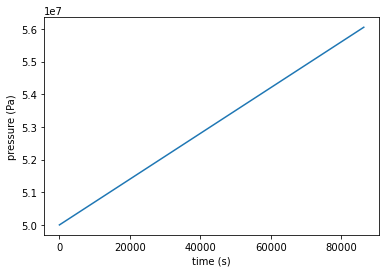

In [22]:
import matplotlib.pyplot as plt
plt.plot(tout, pout)
plt.xlabel("time (s)")
plt.ylabel("pressure (Pa)")
plt.show()

### Make the output (eruption rate from chamber) a function of the volume flux in
As above, 

$$\frac{dP}{dt} = \frac{\mu}{V} \left [Q_{in}(t) - Q_{out} (t) \right ] $$

but now $Q_{out} (t)$ is a function of pressure in the magma chamber. Here it is basically approximated using Poiseuille flow in a cylindrical conduit

$$Q_{out} (t) = \frac{- \pi r^4}{8 \eta} \frac{dP_o}{dx} $$
where $r$ is the conduit radius, $\eta$ is the magma viscosity, and $P_o$ is the overpessure available to drive flow:
$$Q_{out} (t) = \frac{- \pi r^4}{8 \eta} \frac{P_o - P}{dx} $$
$P_o$ is the initial magma pressure (before flow starts), and $P$ is the current pressure of the chamber. This equation assumes that the pressure at the surface is essentially zero (in comparison to the magma pressures). Also, it assumes that initially (a depth just above the magma reservoir), the flow is laminar.

Now the issue is that the pressure $P$ appears on both sides of the equation. See how this is solved in the following.

Finally, we might want to know how the change in pressure ($\Delta P$) affects the change in vertical displacement over the magma reservoir. Using Mogi's model for the maximum vertical displacement due to a change in pressure:

$$\max {U_z}= \frac{(1-\sigma) \Delta P}{\mu} \frac{a^3}{d^2} $$

where $\sigma$ is Poisson's ratio, $\Delta P$ is the change in pressure in the magma reservoir, $\mu$ is the shear modulus, $a$ is the radius of the magma reservoir, and $d$ is the depth to the center of the reservoir.

This is nice! Now the deformation one might model at the surface is not simply a function of pressure, but is related to rates of magma input and output form the magma reservoir.  

The initial condition in this case is that the magma input into the reservoir is 50 m$^3$/s and the initial magma reservoir pressure is lithostatic. As the pressure increases with increasing flux in, the system starts erupting, but initially at a slower rate than the magma comes into the reservoir, until the "system" approaches equilibrium.


In [23]:
import numpy as np
def RK4_2(deriv2,t, p, h, total_t, **kwargs):
    #fourth order R-K solution
    tout = []
    pout = []
    while (t < total_t):
        
        # R-K solution
        dp_dt = deriv2(t,p, **kwargs)
        k1=dp_dt
        dp_dt= deriv2(t+0.5*h, p+0.5*h*k1, **kwargs)
        k2 = dp_dt
        dp_dt  = deriv2(t+0.5*h, p+0.5*h*k2, **kwargs)
        k3 = dp_dt
        dp_dt = deriv2(t+h, p+h*k3, **kwargs)
        k4 = dp_dt
        p += h/6.*(k1+2.*k2+2.*k3+k4)
        t += h
        
        #build output lists
        pout.append(p) # concatenate the lists
        tout.append(t)
        
    
    return tout, pout



In [24]:
def deriv2(t,p,shear_modulus, volume, volume_flux_in, conduit_radius, conduit_length, viscosity, po):
    volume_flux_out = flux_out(p, conduit_radius, conduit_length, viscosity, po)
    return shear_modulus/volume*(volume_flux_in - volume_flux_out)

def flux_out(p, conduit_radius, conduit_length, viscosity, po):
    q = -np.pi*conduit_radius**4/(8*viscosity)*((po-p)/conduit_length)
    
    return q

### 

In [25]:
kwargs={"shear_modulus": 1.4e10, #Pa
       "volume": 1e9, #m3
       "volume_flux_in": 50, #m3/s
       "conduit_radius":5,
       "conduit_length": 3000,
       "viscosity": 10000,
       "po": 0}

crust_density = 2670
gravity = 9.8
#set the initital conditions
t = 0
p = crust_density*gravity*kwargs["conduit_length"]
kwargs["po"] = p
print(p)
#set the step 1000 s
h = 6
total_t = 12000*h
tout, pout = RK4_2(deriv2,t, p, h, total_t, **kwargs)
tout = np.array(tout)/(3600)
pout = np.array(pout) - kwargs["po"]

78498000.00000001


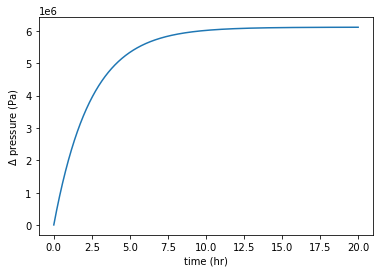

In [26]:
import matplotlib.pyplot as plt
plt.plot(tout, pout)
plt.xlabel("time (hr)")
plt.ylabel("$\Delta$ pressure (Pa)")
plt.show()

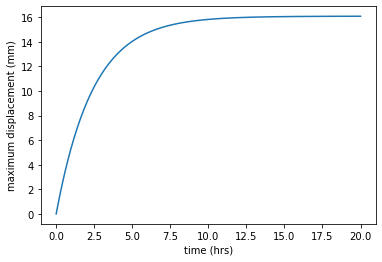

In [27]:
## Mogi's solution for the maximum vertical displacment
# given a pressure source time series
def max_uz(sigma, deltap, shear_modulus, a,d):
    displace = (1-sigma)*deltap/shear_modulus * a**3/d**2
    return displace

sigma = 0.25 # poissons ratio
a = (3/4*kwargs["volume"])**(1/3)  # find radius given volume

d = kwargs["conduit_length"] + a  # find depth given conudit length

displace = max_uz(sigma, pout, kwargs["shear_modulus"], a,d)*1000  #mm displacement

plt.plot(tout, displace)
plt.xlabel("time (hrs)")
plt.ylabel("maximum displacement (mm)")
plt.show()

### More applications
In the example above, the reservoir pressure increases as a function of time, because for all time $Q_{in}(t) \ge Q_{out}(t)$. Of course, very often this is not the case. For example volcanoes often begin to deflate when an effusive eruption begins. Create a case in which the eruption starts (for some reason) and:

$$\frac{dP}{dt} = \frac{\mu}{V} \left [0 - Q_{out} (t) \right ] $$

and

$$Q_{out} (t) = \frac{- \pi r^4}{8 \eta} \frac{dP}{dx} $$

Plot the eruption flow rate and the deflation as a function of time (make sure $Q_{out}$ is inititally relatively small, so it's laminar flow).